# Install acspype

acspype can be installed using pip:

`pip install acspype`

Code documentation for acspype can be found at [https://iantblack.github.io/acspype/](https://iantblack.github.io/acspype/).


## Import Required Packages for this Example

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr

from acspype import ACSDev, ACSTSCor
import acspype.processing as acsproc
from acspype.experimental import estimate_poc

## Shimada 202405 Subset Example
The following example uses a subset of data collected by the [Kavanaugh Lab at Oregon State University](https://blogs.oregonstate.edu/mariakavanaugh/). The data can be found in and downloaded from the [dev_tools/test_files directory of the acspype repository](https://github.com/IanTBlack/acspype/tree/main/dev_tools/test_files). You may need to update the filepaths in the cell below to match you path structure.

In [2]:
data_fp = '../dev_tools/test_files/TEST_SHIMADA_202405.nc'
dev_fp = '../dev_tools/test_files/ACS-00412_2023-05-10.dev'

## Import the Data and Device File

In [3]:
acs = xr.open_dataset(data_fp)
dev = ACSDev(dev_fp)

## Load the Temperature-Salinity (TS) Correction Coefficients
The TS correction coefficients are the pure water absorption and attenuation dependence on salinity and temperature. For simplicity in this example, data will not be flagged or removed. Examples of how to implement these tests can be found in the [ooi_ce02shsp example](

In [4]:
tscor = ACSTSCor().to_xarray()  ## Load the TSCor coefficients as an xarray dataset.

# TSCor coeffs for absorption.
psi_t_a = tscor.psi_t.sel(wavelength=acs.a_wavelength)
psi_s_a = tscor.psi_s_a.sel(wavelength=acs.a_wavelength)

# TSCor coeffs for attenuation.
psi_t_c = tscor.psi_t.sel(wavelength=acs.c_wavelength)
psi_s_c = tscor.psi_s_c.sel(wavelength=acs.c_wavelength)

## Reprocess Data

The processing steps in the cells below follow most of the steps outline in the [Recommended Processing Steps](https://github.com/IanTBlack/acspype/blob/main/info/PROCESSING.md) in the *acspype* documentation.

## Step 1.1

In [5]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(counts = acs.raw_internal_temperature)

## Step 1.3

In [6]:
acs['a_uncorr'] = acsproc.compute_uncorrected(signal_counts=acs.a_signal,
                                                   reference_counts=acs.a_reference, 
                                                   path_length = dev.path_length)

acs['c_uncorr'] = acsproc.compute_uncorrected(signal_counts = acs.c_signal, 
                                                   reference_counts = acs.c_reference, 
                                                   path_length = dev.path_length)

## Step 1.4

In [7]:
acs['a_m_discontinuity'] = acsproc.compute_measured(uncorrected = acs.a_uncorr, 
                                                    internal_temperature = acs.internal_temperature, 
                                                    offset = dev.a_offset, 
                                                    func_delta_t = dev.func_a_delta_t)

acs['c_m_discontinuity'] = acsproc.compute_measured(uncorrected = acs.c_uncorr, 
                                                    internal_temperature = acs.internal_temperature, 
                                                    offset = dev.c_offset, 
                                                    func_delta_t=dev.func_c_delta_t)

## Step 1.6

In [8]:
discontinuity_index = acsproc.find_discontinuity_index(a_wavelength = acs.a_wavelength, 
                                                       c_wavelength = acs.c_wavelength,
                                                       min_wvl = 500, max_wvl = 650)

acs['a_m'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.a_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='a_wavelength')

acs['c_m'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.c_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='c_wavelength')

## Plot Discontinuity Examples

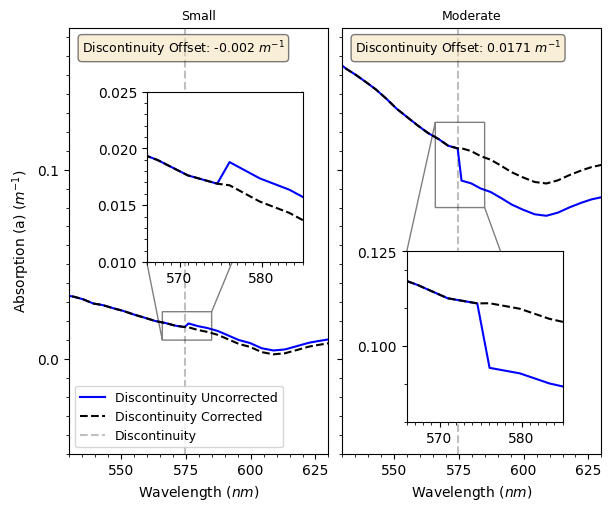

In [9]:
s0 = acs.sel(time = datetime(2024,6,4,3,9,56,344460), method = 'nearest')
s1 = acs.sel(time = datetime(2024,6,4,3,31,34,289202), method = 'nearest')

fig, ax = plt.subplots(1,2, figsize = (6,5), constrained_layout = True, sharex = True,sharey = True)

ax[0].plot(s0.a_wavelength, s0.a_m_discontinuity, label = 'Discontinuity Uncorrected', color = 'blue')
ax[0].plot(s0.a_wavelength, s0.a_m, label = 'Discontinuity Corrected', color = 'black', linestyle = '--')
ax[0].axvline(574.6, color = 'black', linestyle = '--', zorder = 0, alpha = 0.25, label = 'Discontinuity')

ax[1].plot(s1.a_wavelength, s1.a_m_discontinuity, label = 'Discontinuity Uncorrected', color = 'blue')
ax[1].plot(s1.a_wavelength, s1.a_m, label = 'Discontinuity Corrected', color = 'black', linestyle = '--')
ax[1].axvline(574.6, color = 'black', linestyle = '--', zorder = 0, alpha = 0.25,label = 'Discontinuity Location')

ax[-1].set_xlim(530,630)
ax[-1].set_ylim(-0.05,0.175)

ax[-1].xaxis.set_major_locator(MultipleLocator(25))
ax[-1].xaxis.set_minor_locator(MultipleLocator(5))
ax[-1].yaxis.set_major_locator(MultipleLocator(0.1))
ax[-1].yaxis.set_minor_locator(MultipleLocator(0.01))


ax[0].set_ylabel(r'Absorption (a) ($m^{-1}$)')
ax[0].set_xlabel(r'Wavelength ($nm$)')
ax[1].set_xlabel(r'Wavelength ($nm$)')

ax[0].set_title('Small', fontsize = 9)
ax[1].set_title('Moderate', fontsize = 9)

ax[0].legend(loc = 'lower left',fontsize = 9)

# Text Boxes
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
t0 = r"Discontinuity Offset: {} $m^{{-1}}$".format(float(np.round(s0.a_discontinuity_offset,4)))
ax[0].text(0.05, 0.975, t0, transform=ax[0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)
t1 = r"Discontinuity Offset: {} $m^{{-1}}$".format(float(np.round(s1.a_discontinuity_offset,4)))
ax[1].text(0.05, 0.975, t1, transform=ax[1].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# Inset ax0
x1,x2,y1,y2 = 566,585,0.01,0.025
axins0 = ax[0].inset_axes([0.3, 0.45, 0.6, 0.4], xlim=(x1, x2), ylim=(y1, y2))
ax[0].indicate_inset_zoom(axins0, edgecolor="black")
axins0.plot(s0.a_wavelength, s0.a_m_discontinuity, color = 'blue')
axins0.plot(s0.a_wavelength, s0.a_m, color = 'black', linestyle = '--')
axins0.xaxis.set_major_locator(MultipleLocator(10))
axins0.xaxis.set_minor_locator(MultipleLocator(1))
axins0.yaxis.set_major_locator(MultipleLocator(0.005))
axins0.yaxis.set_minor_locator(MultipleLocator(0.001))

# Inset ax1
x1,x2,y1,y2 = 566,585,0.08,0.125
axins1 = ax[1].inset_axes([0.25, 0.075, 0.6, 0.4], xlim=(x1, x2), ylim=(y1, y2))
ax[1].indicate_inset_zoom(axins1, edgecolor="black")
axins1.plot(s1.a_wavelength, s1.a_m_discontinuity, color = 'blue')
axins1.plot(s1.a_wavelength, s1.a_m, color = 'black', linestyle = '--')
axins1.xaxis.set_major_locator(MultipleLocator(10))
axins1.xaxis.set_minor_locator(MultipleLocator(1))
axins1.yaxis.set_major_locator(MultipleLocator(0.025))
axins1.yaxis.set_minor_locator(MultipleLocator(0.01))

plt.savefig('f1.jpg', dpi = 600)

## Step 1.8

In [10]:
tcal = dev.tcal  # The reference temperature value in the device file.

acs['a_mts'] = acsproc.ts_correction(measured = acs.a_m, 
                                     temperature = acs.sea_water_temperature,
                                     salinity = acs.sea_water_practical_salinity, 
                                     psi_temperature = psi_t_a, 
                                     psi_salinity= psi_s_a, 
                                     tcal = tcal)

acs['c_mts'] = acsproc.ts_correction(measured = acs.c_m, 
                                     temperature = acs.sea_water_temperature,
                                     salinity = acs.sea_water_practical_salinity, 
                                     psi_temperature= psi_t_c, 
                                     psi_salinity = psi_s_c, 
                                     tcal = tcal)

## Step 1.9

In [11]:
acs['a_mts'] = acsproc.zero_shift_correction(acs.a_mts)
acs['c_mts'] = acsproc.zero_shift_correction(acs.c_mts)

## Step 3.0

In [12]:
acsi = acsproc.interpolate_common_wavelengths(acs)

## Step 3.1

In [13]:
ref_a = acsi.a_mts.sel(wavelength = 715, method = 'nearest')
ref_c = acsi.c_mts.sel(wavelength = 715, method = 'nearest')

In [14]:
acsi['a_mts_baseline'] = acsproc.baseline_scattering_correction(acsi.a_mts, reference_a = ref_a)
acsi['a_mts_baseline'] = acsproc.zero_shift_correction(acsi.a_mts_baseline)

acsi['a_mts_proportional'] = acsproc.proportional_scattering_correction(acsi.a_mts, acsi.c_mts,
                                                                       reference_a = ref_a, reference_c = ref_c)
acsi['a_mts_proportional'] = acsproc.zero_shift_correction(acsi.a_mts_proportional)

acsi['a_mts_fixed1'] = acsproc.fixed_scattering_correction(acsi.a_mts, acsi.c_mts, epsilon = 0.14)
acsi['a_mts_fixed2'] = acsproc.fixed_scattering_correction(acsi.a_mts, acsi.c_mts, epsilon = 0.18)

## Plot Scattering Correction Examples

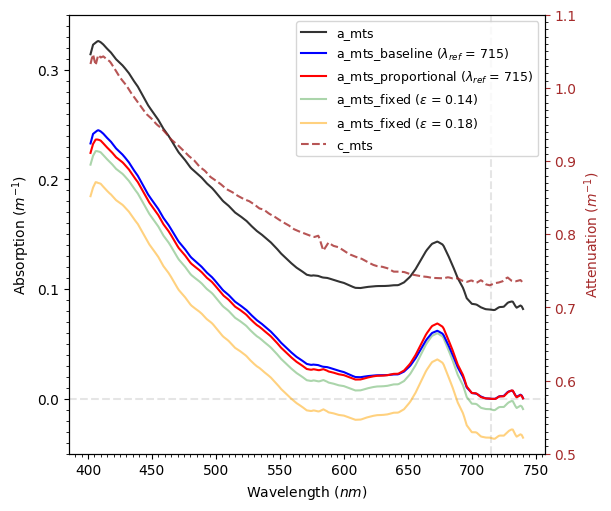

In [15]:
s0 = acsi.sel(time = datetime(2024,6,4,3,31,34,289202), method = 'nearest')

fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)

ax.plot(s0.wavelength, s0.a_mts, color = 'black', label = "a_mts", zorder = 1, alpha = 0.8)
ax.plot(s0.wavelength, s0.a_mts_baseline, color = 'blue', label = r'a_mts_baseline (${\lambda}_{ref}$ = 715)', zorder = 3)
ax.plot(s0.wavelength, s0.a_mts_proportional, color = 'red', label = r'a_mts_proportional (${\lambda}_{ref}$ = 715)', zorder = 3)
ax.plot(s0.wavelength, s0.a_mts_fixed1, color = 'green', label = r'a_mts_fixed ($\epsilon$ = 0.14)', alpha = 0.33, zorder = 2)
ax.plot(s0.wavelength, s0.a_mts_fixed2, color = 'orange', label = r'a_mts_fixed ($\epsilon$ = 0.18)', alpha = 0.5, zorder = 2)
ax.axhline(0, color = 'black', linestyle = '--', zorder = 0, alpha = 0.1)
ax.axvline(715, color = 'black', linestyle = '--', zorder = 0, alpha = 0.1)
ax.plot([],[],color = 'brown', linestyle = '--', label = 'c_mts', zorder = 1, alpha = 0.8)
ax.legend(loc = 'upper right', fontsize = 9)
ax.set_ylim(-0.05,0.35)
ax.set_ylabel(r'Absorption ($m^{-1}$)')
ax.set_xlabel(r'Wavelength ($nm$)')

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

# Second Axis
axc = ax.twinx()
axc.plot(s0.wavelength, s0.c_mts, color = 'brown', linestyle = '--', label = 'c_mts', zorder = 1, alpha = 0.8)

axc.set_ylim(0.5,1.1)
axc.set_ylabel(r'Attenuation ($m^{-1}$)')
axc.xaxis.set_major_locator(MultipleLocator(50))
axc.xaxis.set_minor_locator(MultipleLocator(5))
axc.yaxis.set_major_locator(MultipleLocator(0.1))
axc.yaxis.set_minor_locator(MultipleLocator(0.01))

axc.yaxis.label.set_color('brown')
axc.tick_params(axis='y', colors='brown')

plt.savefig('f2.jpg', dpi = 600)

## Step 5.0 and 6.0

In [16]:
# This is a hacked together function for removing the first 3 minutes and last 30 seconds of a filtration period. 
# Code borrowed from https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/ooi_data_explorations/profilers.py#L53

def cleanup_filtered_periods(g: xr.DataArray, filter_period_length:int = 10 * 60, remove_start: int = 3 * 60, remove_end: int = 15):
    dt = g.where(g['time'].diff('time') > np.timedelta64(filter_period_length, 's'), drop=True).get_index('time')
    fperiods = []
    jback = np.timedelta64(60, 's')  # 
    for i, d in enumerate(dt):
        if i == 0:
            fperiod = g.sel(time=slice(g['time'].values[0], d - jback))
        else:
            fperiod = g.sel(time=slice(dt[i - 1], d - jback))
            
            
        fperiod = fperiod.sel(time = slice(fperiod.time.min() + np.timedelta64(remove_start,'s'), 
                                           fperiod.time.max() - np.timedelta64(remove_end,'s')))    
        
        if len(fperiod.time.values != 0):
            fperiods.append(fperiod)
    
        fperiod = g.sel(time=slice(d, g['time'].values[-1]))
        fperiod = fperiod.sel(time = slice(fperiod.time.min() + np.timedelta64(remove_start,'s'), 
                                           fperiod.time.max() - np.timedelta64(remove_end,'s')))    

        if len(fperiod.time.values != 0):
            fperiods.append(fperiod)
    
    filtered = xr.concat(fperiods, dim = 'time')
    filtered = filtered.drop_duplicates(dim = 'time')
    return filtered

In [17]:
# Split into filtered and unfiltered data.
pg = acsi.where(acs.seawater_state != 1, drop = True)
g = acsi.where(acs.seawater_state != 0, drop = True)

In [18]:
# Cleanup up filtered water periods, smooth, resample, and do nearest neighbor matchup to unfiltered timestamps.
gc = cleanup_filtered_periods(g)
gc = gc.rolling({'time': 60+1}, center = True, min_periods = 1).median()
gc = gc.resample({'time': '15min'}, skipna = True).mean()  # Resample to 15min intervals.
gc = gc.interpolate_na(dim = 'time', method = 'nearest',max_gap = None, limit = None) # Fill NaNs using nearest values.
gi = gc.interp(time = pg.time, method = 'nearest', method_non_numeric = 'nearest', kwargs = {'fill_value': 'extrapolate'})  # Create an interpolated gelbstoff dataset that matches the time of the total seawater dataset.
gi = gi.interpolate_na(dim = 'time', method = 'nearest',max_gap = None, limit = None) 

In [19]:
# Calculate the particulate signal.
# Note: You will need to be careful with the variables. Subtracting variables like latitude, longitude, temperature, and salinity do not make sense here.
# For example, the below results in latitude/longitude subtraction.

dvars = ['a_mts','c_mts','a_mts_baseline','a_mts_proportional']
p = pg[dvars]-gi[dvars]

## Step 7.0

In [20]:
c660 = p.c_mts.sel(wavelength = 660, method = 'nearest')

In [21]:
poc = estimate_poc(c660, slope_offset = 'gardner2006')

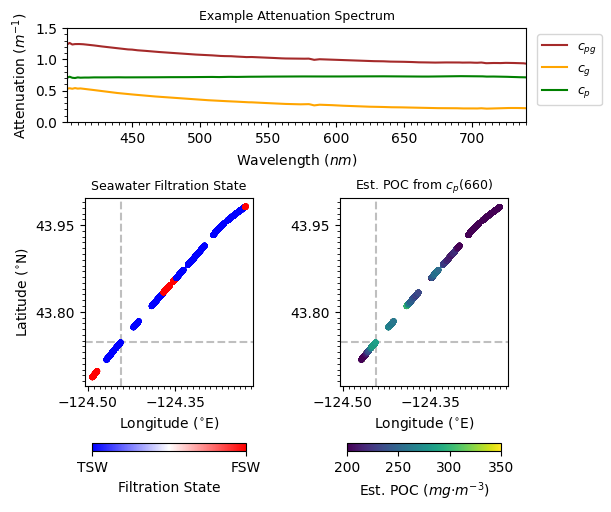

In [22]:
lat = pg.latitude
lon = pg.longitude
ba = (lat.max() - lat.min())/(lon.max() - lon.min())

st0 = acsi.sel(time = datetime(2024,6,4,2,31,34,289202), method = 'nearest')
sg0 = gc.sel(time = datetime(2024,6,4,2,31,34,289202), method = 'nearest')
sp0 = p.sel(time = datetime(2024,6,4,2,31,34,289202), method = 'nearest')

fig = plt.figure(figsize = (6,5), constrained_layout = True)
grid = (3,2)
ax0 = plt.subplot2grid(grid, (0,0), colspan = 2,rowspan = 1)
ax1 = plt.subplot2grid(grid, (1,0), colspan = 1,rowspan = 2)
ax2 = plt.subplot2grid(grid, (1,1), colspan = 1,rowspan = 2, sharey = ax1, sharex = ax1)

ax0.plot(st0.wavelength, st0.c_mts, color = 'brown', label = r"$c_{pg}$")
ax0.plot(sg0.wavelength, sg0.c_mts, color = 'orange', label = r"$c_{g}$")
ax0.plot(sp0.wavelength, sp0.c_mts, color = 'green', label = r"$c_{p}$")
ax0.set_title('Example Attenuation Spectrum', fontsize = 9)
l0 = ax0.legend(bbox_to_anchor = (1.01,1.0), fontsize = 9)
#l0.set_in_layout(False)
ax0.set_ylabel('Attenuation ($m^{-1}$)')
ax0.set_xlabel('Wavelength ($nm$)')
ax0.set_xlim(402,740)
ax0.set_ylim(0,1.5)

ax0.yaxis.set_major_locator(MultipleLocator(0.5))
ax0.yaxis.set_minor_locator(MultipleLocator(0.1))
ax0.xaxis.set_major_locator(MultipleLocator(50))
ax0.xaxis.set_minor_locator(MultipleLocator(5))

_p1 = ax1.scatter(acsi.longitude, acsi.latitude, c = acsi.seawater_state, s = 10, cmap = 'bwr')  
ax1.set_title('Seawater Filtration State',fontsize = 9)
cbar = fig.colorbar(_p1, ax = ax1, label = 'Filtration State', shrink = 0.75, location = 'bottom')
cbar.ax.set_xticks([0,1])
cbar.ax.set_xticklabels(['TSW', 'FSW'])
ax1.set_box_aspect(ba)

_p2 = ax2.scatter(lon, lat,c = poc, s= 10, cmap = 'viridis', vmin = 200, vmax = 350)
fig.colorbar(_p2, ax = ax2,label = r'Est. POC ($mg{\cdot}m^{-3}$)', shrink = 0.75, location = 'bottom')
ax2.set_title(r'Est. POC from $c_p(660)$', fontsize = 9)
ax2.set_box_aspect(ba)

ax2.yaxis.set_major_locator(MultipleLocator(0.15))
ax2.yaxis.set_minor_locator(MultipleLocator(0.01))
ax2.xaxis.set_major_locator(MultipleLocator(0.15))
ax2.xaxis.set_minor_locator(MultipleLocator(0.01))

ax1.set_ylabel(r'Latitude ($^{\circ}$N)')
ax1.set_xlabel(r'Longitude ($^{\circ}$E)')
ax2.set_xlabel(r'Longitude ($^{\circ}$E)')


ax1.axhline(st0.latitude, color = 'black', linestyle = '--', zorder = 0, alpha = 0.25)
ax1.axvline(st0.longitude, color = 'black', linestyle = '--', zorder = 0, alpha = 0.25)

ax2.axhline(st0.latitude, color = 'black', linestyle = '--', zorder = 0, alpha = 0.25)
ax2.axvline(st0.longitude, color = 'black', linestyle = '--', zorder = 0, alpha = 0.25)

plt.savefig('f3.jpg', dpi = 600)